# Training an Image Classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## 1. Load and normalize CIFAR10

Using torchvision, it’s extremely easy to load CIFAR10.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


  dog   cat  bird  frog


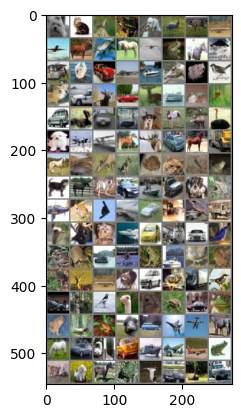

In [125]:
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [126]:
# Check that MPS is available
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps:0


In [127]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device) # switch to gpu

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [128]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion.to(device) # switch to gpu

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# Transfer optimizer state to GPU
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

## 4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

[1,   195] loss: 2.302
[1,   390] loss: 2.291
[2,   195] loss: 2.257
[2,   390] loss: 2.145
[3,   195] loss: 2.026
[3,   390] loss: 1.938
[4,   195] loss: 1.864
[4,   390] loss: 1.786
[5,   195] loss: 1.712
[5,   390] loss: 1.654
[6,   195] loss: 1.610
[6,   390] loss: 1.582
[7,   195] loss: 1.545
[7,   390] loss: 1.515
[8,   195] loss: 1.487
[8,   390] loss: 1.466
[9,   195] loss: 1.444
[9,   390] loss: 1.415
[10,   195] loss: 1.398
[10,   390] loss: 1.372
[11,   195] loss: 1.351
[11,   390] loss: 1.336
[12,   195] loss: 1.309
[12,   390] loss: 1.294
[13,   195] loss: 1.275
[13,   390] loss: 1.253
[14,   195] loss: 1.235
[14,   390] loss: 1.211
[15,   195] loss: 1.204
[15,   390] loss: 1.180
[16,   195] loss: 1.163
[16,   390] loss: 1.141
[17,   195] loss: 1.124
[17,   390] loss: 1.126
[18,   195] loss: 1.091
[18,   390] loss: 1.095
[19,   195] loss: 1.074
[19,   390] loss: 1.064
[20,   195] loss: 1.042
[20,   390] loss: 1.037
[21,   195] loss: 1.017
[21,   390] loss: 1.019
[22,   195

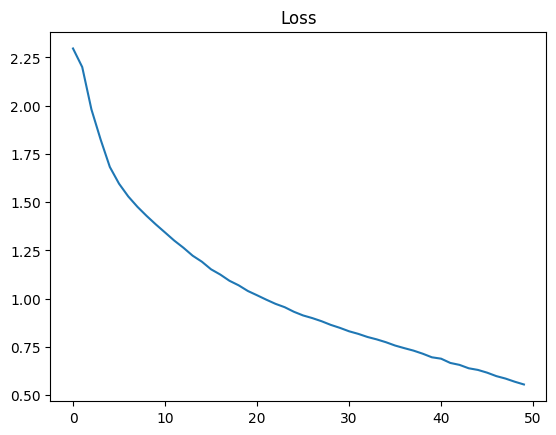

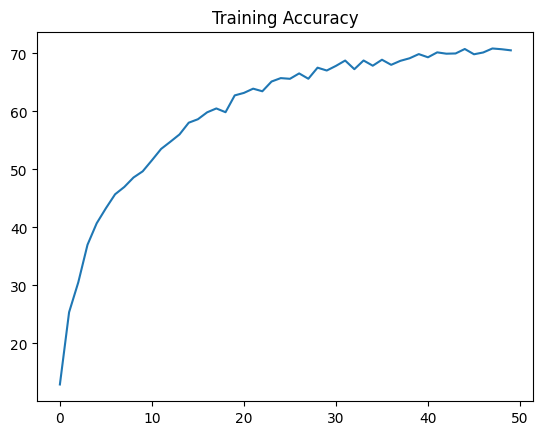

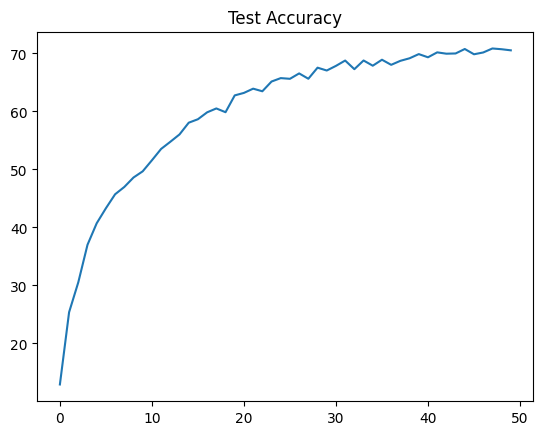

Finished Training


In [ ]:
losses = []
trainAccuracies = []
testAccuracies = []
divisor = len(trainloader) // 2
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss = 0.0
    total, correct = 0, 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputsTraining, labelsTraining = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputsTraining = net(inputsTraining)

        # Training accuracy
        _, predicted = torch.max(outputsTraining, 1)
        total += labelsTraining.size(0)
        correct += (predicted == labelsTraining).sum().item()
        
        # Calculate loss
        loss = criterion(outputsTraining, labelsTraining)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % divisor == divisor - 1:    # print every 'divisor' mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / divisor:.3f}')
            running_loss = 0.0
    trainAccuracies.append(100 * correct / total)

            
    # Test accuracy
    total, correct = 0, 0
    for data in testloader:
        inputsTesting, labelsTesting = data[0].to(device), data[1].to(device)
        outputsTesting = net(inputsTesting)
        
        _, predicted = torch.max(outputsTesting, 1)
        total += labelsTesting.size(0)
        correct += (predicted == labelsTesting).sum().item()
    testAccuracies.append(100 * correct / total)
    
    losses.append(epoch_loss / len(trainloader))

plt.plot(losses)
plt.title("Loss")
plt.show()

plt.plot(trainAccuracies)
plt.title("Training Accuracy")
plt.show()

plt.plot(testAccuracies)
plt.title("Test Accuracy")
plt.show()

print('Finished Training')

In [ ]:
# Let’s quickly save our trained model:
PATH = './models/p1_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

GroundTruth:  cat   ship  ship  plane


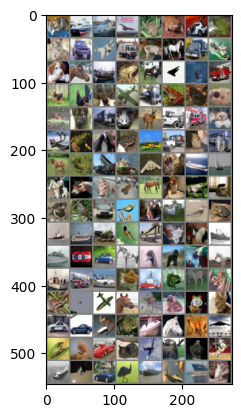

In [131]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [132]:
# Next, let’s load back in our saved model 
# (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

# Okay, now let us see what the neural network thinks these examples above are:
outputs = net(images)

# The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that 
# the image is of the particular class. So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


In [133]:
# Let us look at how the network performs on the whole dataset.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 70 %


In [134]:
# That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). 
# Seems like the network learnt something.

# Hmmm, what are the classes that performed well, and the classes that did not perform well:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.2 %
Accuracy for class: car   is 85.6 %
Accuracy for class: bird  is 54.7 %
Accuracy for class: cat   is 56.5 %
Accuracy for class: deer  is 59.8 %
Accuracy for class: dog   is 65.5 %
Accuracy for class: frog  is 76.2 %
Accuracy for class: horse is 71.7 %
Accuracy for class: ship  is 85.7 %
Accuracy for class: truck is 79.5 %
